In [6]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from glob import glob
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets

In [5]:
#import pycasia

In [7]:
hf = h5py.File('HWDB1.1new.hdf5', 'r')

for key in hf.keys():
    print(key)

trn
tst


In [8]:
%%time
data_train = hf.get('trn/x')
data_train = np.array(data_train)
print(data_train.shape)
train_labels = hf.get('trn/y')
train_labels = np.array(train_labels)
print(train_labels.shape)
data_test = hf.get('tst/x')
data_test = np.array(data_test)
print(data_test.shape)
test_labels = hf.get('tst/y')
test_labels = np.array(test_labels)
print(test_labels.shape)

(897758, 1, 64, 64)
(897758,)
(223991, 1, 64, 64)
(223991,)
CPU times: user 963 ms, sys: 3.99 s, total: 4.95 s
Wall time: 7.82 s


In [9]:
hf.close()

In [0]:
#train_labels=np.zeros(labels_train.shape[0])
#for i in range(labels_train.shape[0]):
#  train_labels[i] = np.argmax(labels_train[i])
#print(train_labels.shape)
#test_labels=np.zeros(labels_test.shape[0])
#for i in range(labels_test.shape[0]):
#  test_labels[i] = np.argmax(labels_test[i])
#print(test_labels.shape)

(897758,)
208.0


In [0]:
#with h5py.File('HWDB1.1new.hdf5', 'w') as f:
#    f.create_dataset('trn/x', data=data_train)
#    f.create_dataset('trn/y', data=train_labels)
#    f.create_dataset('tst/x', data=data_test)
#    f.create_dataset('tst/y', data=test_labels)

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.674,), (0.415,),)])#(0.876,), (0.272,)

In [11]:
class HDF5Dataset(Dataset):
    def __init__(self, X, y, transform):
        super().__init__()
        self.X = X
        self.y = y
        self.transform = transform
        #files = sorted(file_path)
        #self._add_data_infos(str(files), load_data)
            
    def __getitem__(self, index):
        X = self.X[index][0]
        if self.transform:
            X = self.transform(X)
            #X = X.float()
        else:
            X = torch.from_numpy(self.X)

        y = torch.from_numpy(self.y.astype(np.int32))
        return (X, y[index])

    def __len__(self):
        return self.X.shape[0] 

In [22]:
#train_labels=np.zeros(labels_train.shape[0])
#for i in range(labels_train.shape[0]):
#  train_labels[i] = np.argmax(labels_train[i])
#print(train_labels.shape)
#print(train_labels[208])

In [0]:
#test_labels=np.zeros(labels_test.shape[0])
#for i in range(labels_test.shape[0]):
#  test_labels[i] = np.argmax(labels_test[i])
#print(test_labels.shape)
#print(test_labels[:4])

(223991,)
[630. 631. 632. 633.]


In [20]:
# Hyperparameters
num_epochs = 1
batch_size = 500
learning_rate = 0.001

In [21]:
train_dataset = HDF5Dataset(data_train, train_labels, transform = transform)
test_dataset = HDF5Dataset(data_test, test_labels, transform = transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
class HierarcicalNet(nn.Module):
    def __init__(self):
        super(HierarcicalNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Dropout(0.25),

            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Dropout(0.25),

            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Dropout(0.25))
        
        self.classifier = nn.Linear(1024, 3755)
        
        self.extractor = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.25))
        

    def forward(self, x):
        out = self.feature(x)
        out = out.reshape(out.size(0), -1)
        out = self.extractor(out)
        out = self.classifier(out)
        return out

    def clustering(self, x):
        out = self.feature(x)
        out = out.reshape(out.size(0), -1)
        out = self.extractor(out)
        return out

In [24]:
model = HierarcicalNet()
model.load_state_dict(torch.load('new_model512.ckpt'))

In [29]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        labels = labels.type(torch.LongTensor)
        loss = loss_function(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0 or i+1 == 1796:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))
        #if (i + 1) % 300 == 0 or (i + 1) == 1796:
            #torch.save(model.state_dict(), './model_3755.ckpt')

Epoch [1/1], Step [100/1796], Loss: 0.0789, Accuracy: 97.60%
Epoch [1/1], Step [200/1796], Loss: 0.0616, Accuracy: 98.40%
Epoch [1/1], Step [300/1796], Loss: 0.1087, Accuracy: 96.80%
Epoch [1/1], Step [400/1796], Loss: 0.1191, Accuracy: 95.80%
Epoch [1/1], Step [500/1796], Loss: 0.0730, Accuracy: 97.40%
Epoch [1/1], Step [600/1796], Loss: 0.0956, Accuracy: 96.60%
Epoch [1/1], Step [700/1796], Loss: 0.1162, Accuracy: 95.80%
Epoch [1/1], Step [800/1796], Loss: 0.1422, Accuracy: 95.40%
Epoch [1/1], Step [900/1796], Loss: 0.1265, Accuracy: 96.40%
Epoch [1/1], Step [1000/1796], Loss: 0.0958, Accuracy: 97.00%
Epoch [1/1], Step [1100/1796], Loss: 0.1228, Accuracy: 96.80%
Epoch [1/1], Step [1200/1796], Loss: 0.2004, Accuracy: 94.00%
Epoch [1/1], Step [1300/1796], Loss: 0.1574, Accuracy: 96.00%
Epoch [1/1], Step [1400/1796], Loss: 0.0905, Accuracy: 97.20%
Epoch [1/1], Step [1500/1796], Loss: 0.1450, Accuracy: 96.20%
Epoch [1/1], Step [1600/1796], Loss: 0.1707, Accuracy: 94.60%
Epoch [1/1], Step

In [56]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy of the model on test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on test images: 93.69349661370323 %


In [32]:
#torch.save(model.state_dict(), './model_3755.ckpt')

In [12]:
class_powers = np.zeros(3755)
for j in range(train_labels.shape[0]):
    class_powers[int(train_labels[j])] += 1
print(class_powers)

[240. 240. 240. ... 236. 238. 235.]


In [13]:
unique, counts = np.unique(class_powers, return_counts=True)
print(unique)
print(counts)

[215. 220. 222. 223. 225. 226. 227. 229. 231. 232. 233. 234. 235. 236.
 237. 238. 239. 240. 241.]
[   1    1    1    1    1    1    2    1    1    7    6   13   27   86
  184  467 1166 1769   20]


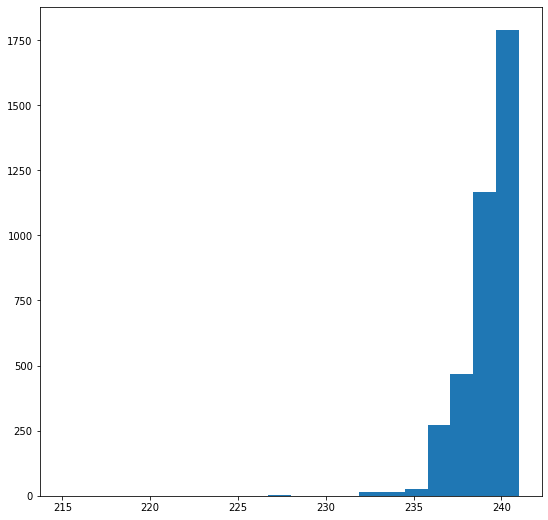

In [14]:
plt.figure(figsize=(9,9))
plt.hist(class_powers, bins = 20);

In [34]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from skimage.transform import resize

In [32]:
X_part, y_part = shuffle(data_train, train_labels, n_samples = int(train_labels.shape[0] / 8), random_state = 0)

#X_train = np.zeros((X_part.shape[0], 24, 24))
#for i in range(X_part.shape[0]):
#    X_train[i] = resize(X_part[i, 0], (24, 24))

#X_train = X_train.reshape(-1, 24 * 24)
#print(X_train.shape)

(112219, 576)


In [36]:
part_dataset = HDF5Dataset(X_part, y_part, transform = transform)
part_loader = DataLoader(dataset=part_dataset, batch_size=500,shuffle=True)

#### PCA

In [34]:
from sklearn import decomposition

In [0]:
pca = decomposition.PCA().fit(X_train)

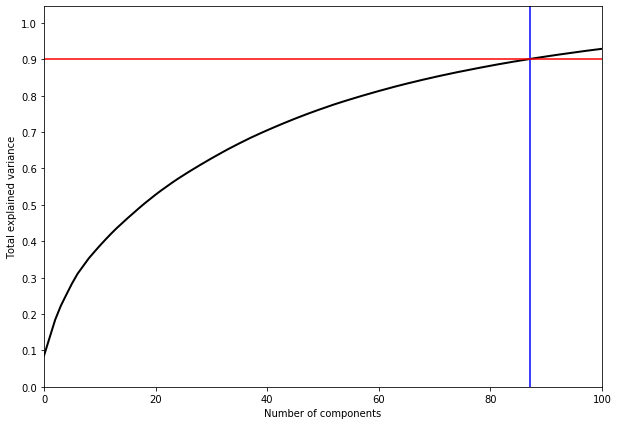

In [0]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 100)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(87, c='b')
plt.axhline(0.9, c='r')
plt.show()

Text(0.5, 1.0, 'Hier. PCA projection')

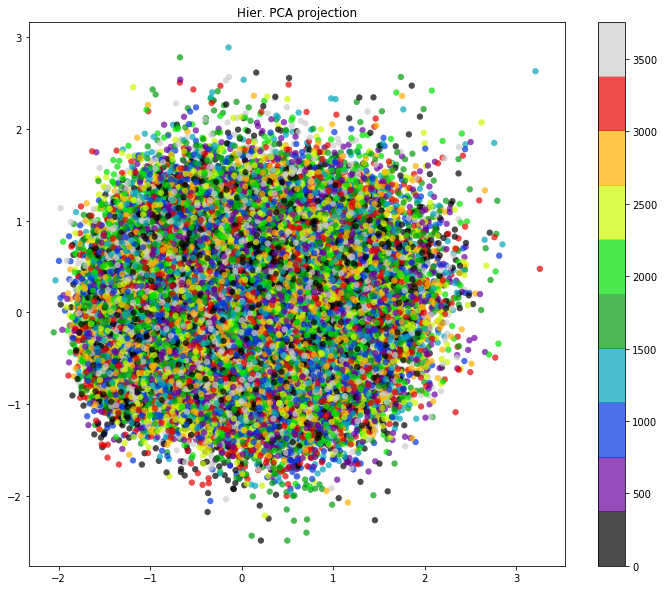

In [0]:
pca = decomposition.PCA(n_components = 87, random_state=17)

X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y_part,
edgecolor='none', alpha=0.7, s=40,
cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('Hier. PCA projection')

In [0]:
cluster = KMeans(n_clusters = 400, random_state = 17).fit(X_pca)

### Extracting feature vectors

In [37]:
extractor = []
for i, (images, labels) in enumerate(part_loader):
    X = model.clustering(images)
    X = X.detach().numpy().reshape(X.shape[0] * X.shape[1])
    if (i == 0):
        print(X.shape)
    extractor.extend(list(X))
    
extractor = np.asarray(extractor).reshape((X_part.shape[0], 1024))
for i in range(extractor.shape[0]):
    extractor[i] = extractor[i] / np.linalg.norm(extractor[i])

(512000,)


### Clustering to 400 clusters

In [0]:
cluster = KMeans(n_clusters = 400, random_state = 0).fit(extractor)
print(cluster.labels_)
print(len(cluster.labels_))
print(len(cluster.cluster_centers_))
#print(cluster.cluster_centers_)

[213 178  52 ... 217 369 108]
89775
400


(array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  2.,  1.,  2.,  3.,  3.,
         2.,  3.,  5.,  4.,  6.,  8.,  5.,  3., 13.,  9.,  9.,  8.,  9.,
        13., 13., 14., 11., 12., 17., 10., 12., 11., 10., 22.,  7.,  8.,
        11.,  7., 10., 14.,  9., 11.,  3.,  5.,  5.,  4.,  6.,  5.,  4.,
         5.,  8.,  2.,  1.,  2.,  1.,  2.,  2.,  5.,  3.,  1.,  4.,  0.,
         0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([105.  , 108.38, 111.76, 115.14, 118.52, 121.9 , 125.28, 128.66,
        132.04, 135.42, 138.8 , 142.18, 145.56, 148.94, 152.32, 155.7 ,
        159.08, 162.46, 165.84, 169.22, 172.6 , 175.98, 179.36, 182.74,
        186.12, 189.5 , 192.88, 196.26, 199.64, 203.02, 206.4 , 209.78,
        213.16, 216.54, 219.92, 223.3 , 226.68, 230.06, 233.44, 236.82,
        240.2 , 243.58, 246.96, 250.34, 253.72, 257.1 , 260.48, 263.86,
  

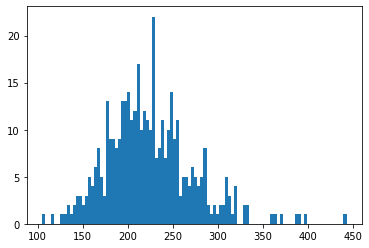

In [0]:
unique, counts = np.unique(labels, return_counts=True)
plt.hist(counts, bins = 100)

In [0]:
class_to_cluster = np.zeros(3755)
for i in range(3755): #for each class
  objects = []
  cluster_frequency = {}
  for j in range(len(y_part)): #for all the objects
    if (y_part[j] == i):
      objects.append(j) #array consisting of numbers of objects with class label i

  for j in objects: #labels[j] - cluster number for object
    if labels[j] in cluster_frequency.keys():
      cluster_frequency[labels[j]] += 1
    else:
      cluster_frequency[labels[j]] = 1

  max_cluster_in_class = -1
  amounts_of_objects_in_cluster = 0
  for key in cluster_frequency: #looking for cluster with maximum amount of objects
    if cluster_frequency[key] > amounts_of_objects_in_cluster:
      amounts_of_objects_in_cluster = cluster_frequency[key]
      max_cluster_in_class = key

  class_to_cluster[i] = max_cluster_in_class

(array([43., 29., 48., 41., 29., 30., 28., 45., 55., 26., 48., 36., 27.,
        40., 35., 33., 31., 39., 28., 30., 24., 28., 32., 43., 30., 20.,
        41., 38., 47., 28., 40., 42., 36., 31., 34., 45., 46., 27., 29.,
        45., 30., 43., 56., 31., 48., 29., 63., 41., 41., 58., 38., 44.,
        41., 26., 40., 43., 27., 41., 30., 33., 48., 46., 50., 57., 33.,
        22., 49., 46., 56., 35., 37., 36., 23., 36., 26., 55., 31., 35.,
        50., 29., 18., 36., 51., 47., 39., 38., 30., 30., 36., 37., 29.,
        45., 41., 30., 46., 32., 33., 41., 28., 38.]),
 array([  0.  ,   3.99,   7.98,  11.97,  15.96,  19.95,  23.94,  27.93,
         31.92,  35.91,  39.9 ,  43.89,  47.88,  51.87,  55.86,  59.85,
         63.84,  67.83,  71.82,  75.81,  79.8 ,  83.79,  87.78,  91.77,
         95.76,  99.75, 103.74, 107.73, 111.72, 115.71, 119.7 , 123.69,
        127.68, 131.67, 135.66, 139.65, 143.64, 147.63, 151.62, 155.61,
        159.6 , 163.59, 167.58, 171.57, 175.56, 179.55, 183.54, 187.53,
  

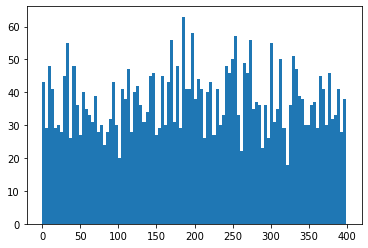

In [0]:
plt.hist(class_to_cluster, bins = 100)

### Clustering to 800 clusters

In [42]:
CLUSTERS_NUM = 800

In [43]:
%%time
cluster = KMeans(n_clusters = CLUSTERS_NUM, random_state = 0).fit(extractor)
print(cluster.labels_)
print(len(cluster.labels_))
print(len(cluster.cluster_centers_))
#print(cluster.cluster_centers_)

[232 545 625 ...  12 264 340]
112219
800
CPU times: user 15h 44min 12s, sys: 1d 16h 47min 47s, total: 2d 8h 32min
Wall time: 1h 43min 44s


In [45]:
labels = cluster.labels_

In [46]:
y_part.max()

3754.0

In [50]:
unique, counts = np.unique(labels, return_counts=True)

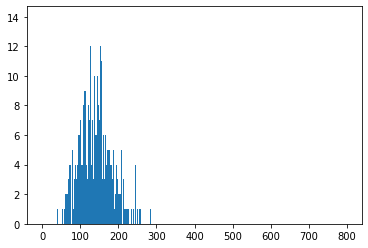

In [51]:
plt.hist(counts, bins = unique);

In [52]:
class_to_cluster = np.zeros(3755)
for i in range(3755): #for each class
  objects = []
  cluster_frequency = {}
  for j in range(len(y_part)): #for all the objects
    if (y_part[j] == i):
      objects.append(j) #array consisting of numbers of objects with class label i

  for j in objects: #labels[j] - cluster number for object
    if labels[j] in cluster_frequency.keys():
      cluster_frequency[labels[j]] += 1
    else:
      cluster_frequency[labels[j]] = 1

  max_cluster_in_class = -1
  amounts_of_objects_in_cluster = 0
  for key in cluster_frequency: #looking for cluster with maximum amount of objects
    if cluster_frequency[key] > amounts_of_objects_in_cluster:
      amounts_of_objects_in_cluster = cluster_frequency[key]
      max_cluster_in_class = key

  class_to_cluster[i] = max_cluster_in_class

In [54]:
cluster_labels_train = np.zeros(data_train.shape[0])
for i in range(len(train_labels)):
  cluster_labels_train[i] = class_to_cluster[int(train_labels[i])]
print(cluster_labels_train.shape)
print(cluster_labels_train[:5])

(897758,)
[410. 109. 226. 145. 710.]


In [55]:
cluster_powers = np.zeros((CLUSTERS_NUM, 2))
for i in range(cluster_labels_train.shape[0]):
  cluster_powers[int(cluster_labels_train[i]), 0] += 1
for i in range(CLUSTERS_NUM):
  cluster_powers[i, 1] = i
cluster_powers = sorted(cluster_powers, key=lambda a_entry: a_entry[0]) 
print(cluster_powers[:20])

[array([ 0., 24.]), array([ 0., 52.]), array([  0., 117.]), array([  0., 152.]), array([  0., 219.]), array([  0., 328.]), array([  0., 339.]), array([  0., 363.]), array([  0., 385.]), array([  0., 389.]), array([  0., 408.]), array([  0., 449.]), array([  0., 455.]), array([  0., 470.]), array([  0., 474.]), array([  0., 513.]), array([  0., 519.]), array([  0., 548.]), array([  0., 549.]), array([  0., 577.])]


In [56]:
cluster_powers = np.array(cluster_powers)
print(cluster_powers[:5])

[[  0.  24.]
 [  0.  52.]
 [  0. 117.]
 [  0. 152.]
 [  0. 219.]]


In [57]:
cluster_powers.shape

(800, 2)

In [59]:
def cluster_exchange(n):
    for i in range(len(cluster_powers)):
        if (cluster_powers[i][1] == n):
            return i
print(cluster_exchange(141))
print(cluster_exchange(371))

190
486


In [60]:
new_cluster_labels_train = np.zeros(cluster_labels_train.shape[0])
for i in range(new_cluster_labels_train.shape[0]):
    new_cluster_labels_train[i] = cluster_exchange(cluster_labels_train[i])

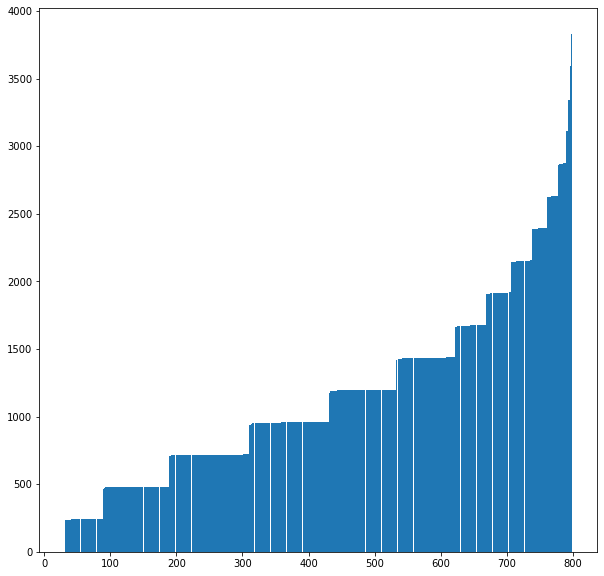

In [61]:
plt.figure(figsize=(10,10))
plt.hist(new_cluster_labels_train, bins = 800);

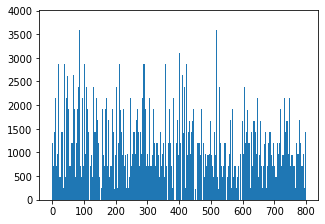

In [64]:
plt.figure(figsize=(5, 3.5))
plt.hist(cluster_labels_train, bins = 800);

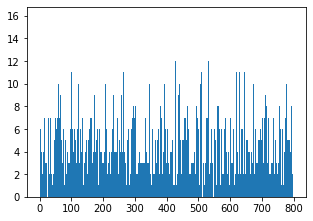

In [65]:
plt.figure(figsize=(5, 3.5))
plt.hist(class_to_cluster, bins = 800);

In [66]:
new_class_to_cluster = np.zeros(class_to_cluster.shape[0])
for i in range(new_class_to_cluster.shape[0]):
    new_class_to_cluster[i] = cluster_exchange(class_to_cluster[i])

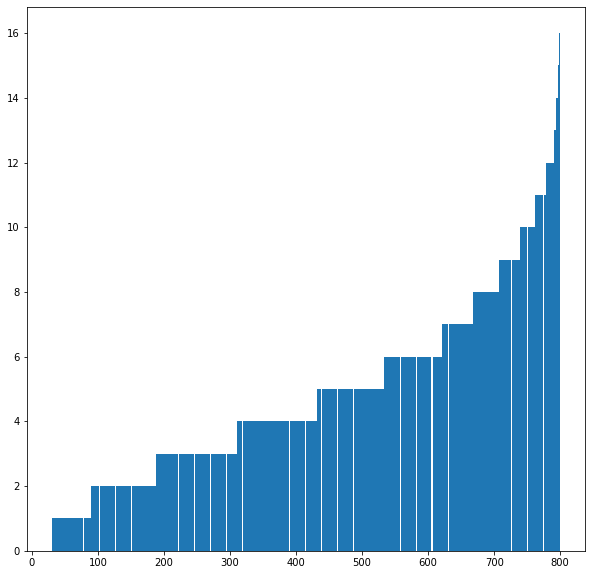

In [67]:
plt.figure(figsize=(10,10))
plt.hist(new_class_to_cluster, bins = 800);

### Creating dataset with cluster labels


In [72]:
lens = np.zeros(800)
for i in range(new_cluster_labels_train.shape[0]):
  lens[int(new_cluster_labels_train[i])] += 1
print(lens[:10])
print(lens[790:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[2876. 3110. 3111. 3112. 3342. 3344. 3348. 3591. 3591. 3829.]


In [73]:
print(len(np.unique(lens)))
print(np.unique(lens))

148
[   0.  234.  236.  237.  238.  239.  240.  462.  473.  475.  476.  477.
  478.  479.  480.  481.  699.  705.  710.  712.  713.  714.  715.  716.
  717.  718.  719.  720.  721.  938.  941.  942.  945.  950.  952.  953.
  954.  955.  956.  957.  958.  959.  960. 1178. 1189. 1190. 1191. 1192.
 1193. 1194. 1195. 1196. 1197. 1198. 1199. 1200. 1422. 1424. 1427. 1428.
 1429. 1430. 1431. 1432. 1433. 1434. 1435. 1436. 1437. 1438. 1439. 1654.
 1663. 1666. 1667. 1669. 1671. 1672. 1673. 1674. 1675. 1676. 1677. 1678.
 1679. 1908. 1909. 1910. 1911. 1912. 1913. 1914. 1915. 1916. 1917. 1918.
 1920. 2142. 2145. 2147. 2148. 2149. 2150. 2151. 2152. 2153. 2154. 2155.
 2156. 2386. 2387. 2389. 2390. 2391. 2392. 2393. 2394. 2395. 2396. 2397.
 2398. 2623. 2624. 2626. 2627. 2629. 2631. 2632. 2634. 2635. 2636. 2861.
 2865. 2867. 2868. 2869. 2870. 2873. 2874. 2876. 3110. 3111. 3112. 3342.
 3344. 3348. 3591. 3829.]


In [74]:
print(lens.min())
print(lens.max())
print(np.mean(lens))
print(np.std(lens))

0.0
3829.0
1122.1975
698.0636725928015


In [75]:
cluster_labels_test = np.zeros(data_test.shape[0])
for i in range(len(test_labels)):
  cluster_labels_test[i] = class_to_cluster[int(test_labels[i])]
print(cluster_labels_test.shape)
print(cluster_labels_test[:5])

(223991,)
[159. 370. 536. 523. 787.]


In [0]:
#with h5py.File('HWDB1.1subset_cluster.hdf5', 'w') as f:
#  f.create_dataset('trn/y', data=new_cluster_labels_train)
#  f.create_dataset('trn/x', data=data_train)
#  f.create_dataset('tst/y', data=cluster_labels_test)
#  f.create_dataset('tst/x', data=data_test)

In [25]:
with h5py.File('HWDB1.1subset_cluster.hdf5', 'r') as f:
  for key in f.keys():
    print(key)
    
  data_train = f.get('trn/x')
  data_train = np.array(data_train)
  print(data_train.shape)

  cluster_labels_train = f.get('trn/y')
  cluster_labels_train = np.array(cluster_labels_train)
  print(cluster_labels_train.shape)

  data_test = f.get('tst/x')
  data_test = np.array(data_test)
  print(data_test.shape)

  cluster_labels_test = f.get('tst/y')
  cluster_labels_test = np.array(cluster_labels_test)
  print(cluster_labels_test.shape)

trn
tst
(897758, 1, 64, 64)
(897758,)
(223991, 1, 64, 64)
(223991,)


### First stage: training net with clusters as labels

In [0]:
# Hyperparameters
num_epochs = 1
batch_size = 500
learning_rate = 0.001

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.674,), (0.415,),)])#(0.876,), (0.272,)

In [0]:
cluster_dataset = HDF5Dataset(data_train, cluster_labels_train, transform = transform)
cluster_loader = DataLoader(dataset = cluster_dataset, batch_size = batch_size, shuffle=True)

In [0]:
CLUSTERS_NUM = 800

In [0]:
class ClusterNet(nn.Module):
    def __init__(self):
        super(ClusterNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Dropout(0.25),

            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Dropout(0.25))
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1600),
            nn.BatchNorm1d(1600),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1600, CLUSTERS_NUM))
        

    def forward(self, x):
        out = self.feature(x)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out

model = ClusterNet()

In [31]:
model.load_state_dict(torch.load('./cluster_800_model.ckpt'))

<All keys matched successfully>

In [0]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
total_step = len(cluster_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
  for i, (images, cl_labels) in enumerate(cluster_loader):
    outputs = model(images)
    cl_labels = cl_labels.type(torch.LongTensor)
    loss = loss_function(outputs, cl_labels)
    loss_list.append(loss.item())

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = cl_labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == cl_labels).sum().item()
    acc_list.append(correct / total)

    if (i + 1) % 100 == 0 or (i + 1) == 1796:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))
    if (i + 1) % 200 == 0 or (i + 1) == 1796:
      torch.save(model.state_dict(), './cluster_800_model.ckpt')
    #if (i + 1) == 1796:
     #break

Epoch [1/1], Step [100/1796], Loss: 0.4489, Accuracy: 87.00%
Epoch [1/1], Step [200/1796], Loss: 0.6118, Accuracy: 84.60%
Epoch [1/1], Step [300/1796], Loss: 0.5080, Accuracy: 85.80%
Epoch [1/1], Step [400/1796], Loss: 0.5463, Accuracy: 86.60%
Epoch [1/1], Step [500/1796], Loss: 0.5824, Accuracy: 85.60%
Epoch [1/1], Step [600/1796], Loss: 0.4899, Accuracy: 86.40%
Epoch [1/1], Step [700/1796], Loss: 0.5328, Accuracy: 85.00%
Epoch [1/1], Step [800/1796], Loss: 0.6160, Accuracy: 84.80%
Epoch [1/1], Step [900/1796], Loss: 0.5191, Accuracy: 86.20%
Epoch [1/1], Step [1000/1796], Loss: 0.5620, Accuracy: 85.60%
Epoch [1/1], Step [1100/1796], Loss: 0.4974, Accuracy: 87.00%
Epoch [1/1], Step [1200/1796], Loss: 0.4053, Accuracy: 88.00%
Epoch [1/1], Step [1300/1796], Loss: 0.5415, Accuracy: 85.20%
Epoch [1/1], Step [1400/1796], Loss: 0.5470, Accuracy: 85.20%
Epoch [1/1], Step [1500/1796], Loss: 0.4600, Accuracy: 86.80%
Epoch [1/1], Step [1600/1796], Loss: 0.4175, Accuracy: 91.60%
Epoch [1/1], Step

In [0]:
torch.save(model.state_dict(), './cluster_800_model.ckpt')

In [0]:
cluster_test_dataset = HDF5Dataset(data_test, cluster_labels_test, transform = transform)
cluster_test_loader = DataLoader(dataset = cluster_test_dataset, batch_size = batch_size, shuffle=False)

In [0]:
# Test the cluster model (first-level classifier)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, cl_labels in cluster_test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += cl_labels.size(0)
        correct += (predicted == cl_labels).sum().item()

print('Test Accuracy of the model on test images: {} %'.format((correct / total) * 100))

In [0]:
X, cl, y = shuffle(data_train, cluster_labels_train, train_labels, n_samples = int(train_labels.shape[0]/8), random_state = 17)
print(X.shape)

(112219, 1, 64, 64)


In [0]:
#with h5py.File('subset.hdf5', 'w') as f:
#    f.create_dataset('X', data=X)
#    f.create_dataset('cl', data=cl)
#    f.create_dataset('y', data=y)

with h5py.File('subset.hdf5', 'r') as f:
  X = f.get('X')
  X = np.array(X)
  print(X.shape)

  cl = f.get('cl')
  cl = np.array(cl)
  print(cl.shape)

  y = f.get('y')
  y = np.array(y)
  print(y.shape)


(112219, 1, 64, 64)
(112219,)
(112219,)


In [0]:
dataset = HDF5Dataset(X, cl, transform = transform)
loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle=False)

In [0]:
net_labels = []

In [0]:
for i, (images, cl_labels) in enumerate(loader):
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    net_labels.extend(predicted)

In [0]:
net_labels = np.array(net_labels)
print(net_labels.shape)

(112219,)


In [0]:
dist = np.zeros((int(y.max() + 1), int(cl.max() + 1)))
print(dist.shape)
#for each class and for each cluster count the number of elements from X related to i class and classified to j cluster
for k in range (X.shape[0]):
  dist[int(y[k]), int(net_labels[k])] += 1

(3755, 800)


In [0]:
distribution = np.zeros((dist.shape[0], dist.shape[1]))
for i in range(dist.shape[0]):
  sum_class = sum(dist[i, :])
  for j in range(dist.shape[1]):
    distribution[i, j] = dist[i, j] / sum_class

In [0]:
list_of_cluster_dist = []
for i in range(distribution.shape[0]):
  current_list = []
  for j in range(distribution.shape[1]):
    if (distribution[i, j] != 0):
      current_list.append([distribution[i, j], j])
  current_list.sort(reverse = True)
  list_of_cluster_dist.append(current_list)
print(len(list_of_cluster_dist))

3755


In [0]:
classes_in_cluster = [] #array of classes in particular cluster
for i in range(dist.shape[1]):
  classes_in_cluster.append([])

for i in range(len(list_of_cluster_dist)):
  list_ = list_of_cluster_dist[i]
  #print(len(list_), list_)
  T = 0
  it = 0
  T_acc = 1
  while (T < T_acc and it < len(list_)):
    classes_in_cluster[list_[it][1]].append(i)
    T += list_[it][0]
    it += 1

In [0]:
print(np.max(lens))
print(np.min(lens))
print(np.mean(lens))
print(np.std(lens))

44
0
10.60625
5.987588073464974


(array([16., 11., 22.,  0., 26., 42., 50.,  0., 40., 50., 71.,  0., 59.,
        53.,  0., 47., 54., 39.,  0., 27., 27., 30.,  0., 26., 24., 20.,
         0., 18.,  9.,  0., 11.,  7.,  4.,  0.,  5.,  3.,  2.,  0.,  3.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.        ,  0.73333333,  1.46666667,  2.2       ,  2.93333333,
         3.66666667,  4.4       ,  5.13333333,  5.86666667,  6.6       ,
         7.33333333,  8.06666667,  8.8       ,  9.53333333, 10.26666667,
        11.        , 11.73333333, 12.46666667, 13.2       , 13.93333333,
        14.66666667, 15.4       , 16.13333333, 16.86666667, 17.6       ,
        18.33333333, 19.06666667, 19.8       , 20.53333333, 21.26666667,
        22.        , 22.73333333, 23.46666667, 24.2       , 24.93333333,
        25.66666667, 26.4       , 27.13333333, 27.86666667, 28.6       ,
        29.33333333, 30.06666667, 30.8       , 31.53333333, 32.26666667,
 

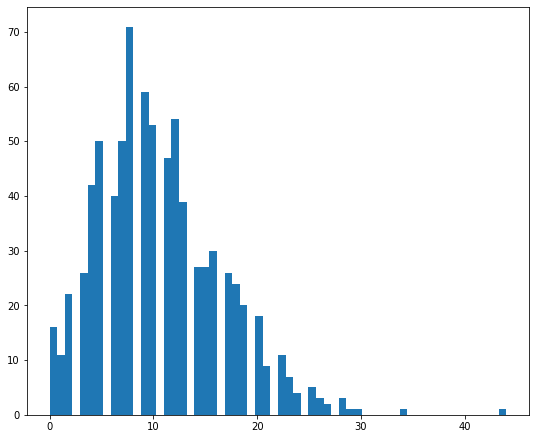

In [0]:
plt.figure(figsize=(9, 7.5))
plt.hist(lens, bins = 60)

#### Saving data series

In [0]:
%cd './SecondLevel2'

/content/drive/My Drive/SecondLevel2


In [0]:
#with open('classes_in_cluster.txt', 'w') as file:  
#    for list_ in classes_in_cluster:
#      file.write('%d\n' % len(list_))
#      for item in list_:
#        file.write('%d\n' % item)

In [0]:
classes_in_cluster = []

with open('classes_in_cluster.txt', 'r') as file:
  for i in range(800):
    list_ = []
    length = int(file.readline())
    for j in range(length):
      list_.append(int(file.readline()))
    classes_in_cluster.append(list_)
print(len(classes_in_cluster))

800


In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.674,), (0.415,))]) #(0.872,)

num_epochs = 7
batch_size = 40
learning_rate = 0.001

### Second stage: learning 800 clusters

In [0]:
problem = []
for i in range(len(accuracy)):
  if (accuracy[i] > 0 and accuracy[i] < 89.):
    problem.append(i)
print(problem)
for j in range(len(problem)):
  print(accuracy[problem[j]])
for j in range(len(problem)):
  print(len(classes_in_cluster[problem[j]]))  

In [0]:
%%time
acc = []
for k in range(785, 800):
  list_ = classes_in_cluster[k]
  data_ = []
  labels_ = []
  test_ = []
  t_labels_ = []

  if (len(list_) > 16):
    num_epochs = 10
  else:
    num_epochs = 7

  for j in range(train_labels.shape[0]):
    for l in range(len(list_)):
      if (train_labels[j] == list_[l]):
        data_.append(data_train[j])
        labels_.append(l)

  for j in range(test_labels.shape[0]):
    for l in range(len(list_)):
      if (test_labels[j] == list_[l]):
        test_.append(data_test[j])
        t_labels_.append(l)
      
  data_ = np.array(data_)
  labels_ = np.array(labels_)

  test_ = np.array(test_)
  t_labels_ = np.array(t_labels_)

  if (data_.shape[0] > 0):
    dataset = HDF5Dataset(data_, labels_, transform = transform)
    loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle=True)

    test_dataset = HDF5Dataset(test_, t_labels_, transform = transform)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False)
    
    class SecondLevelNet(nn.Module):
      def __init__(self):
          super(SecondLevelNet, self).__init__()
          self.feature = nn.Sequential(
              nn.Conv2d(1, 64, 3, stride=1, padding=1),
              nn.BatchNorm2d(64),
              nn.ReLU(),
              nn.MaxPool2d(2, 2),

              nn.Conv2d(64, 128, 3, stride=1, padding=1),
              nn.BatchNorm2d(128),
              nn.ReLU(),
              nn.MaxPool2d(2, 2),

              nn.Conv2d(128, 256, 3, stride=1, padding=1),
              nn.BatchNorm2d(256),
              nn.ReLU(),
              nn.MaxPool2d(2, 2),

              nn.Dropout(),

              nn.Conv2d(256, 512, 3, stride=1, padding=1),
              nn.BatchNorm2d(512),
              nn.ReLU(),
              nn.MaxPool2d(2, 2),

              #nn.Dropout())

              nn.Conv2d(512, 512, 3, stride=1, padding=1),
              nn.BatchNorm2d(512),
              nn.ReLU(),
              nn.MaxPool2d(2, 2),
              
              nn.Dropout())
          
          self.classifier = nn.Sequential(
              nn.Linear(512 * 2 * 2, 512),
              nn.BatchNorm1d(512),
              nn.Dropout(),
              nn.ReLU(),
              nn.Linear(512, len(list_)))
          

      def forward(self, x):
          out = self.feature(x)
          out = out.reshape(out.size(0), -1)
          out = self.classifier(out)
          return out

    model = SecondLevelNet()
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(loader)
    loss_list = []
    acc_list = []
    for epoch in range(num_epochs):
      for i, (images, labs) in enumerate(loader):
          outputs = model(images)
          labs = labs.type(torch.LongTensor)
          loss = loss_function(outputs, labs)
          loss_list.append(loss.item())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Track the accuracy
          total = labs.size(0)
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labs).sum().item()
          acc_list.append(correct / total)

          #if (i + 1) % 100 == 0:
          #  print('Classifier: {}, Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
          #          .format(k + 1, epoch + 1, num_epochs, i + 1, total_step, loss.item(),
          #                  (correct / total) * 100))

    model.eval()

    with torch.no_grad():
      correct = 0
      total = 0
      for images, label in test_loader:
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += label.size(0)
          correct += (predicted == label).sum().item()
    acc.append((correct / total) * 100)
    print('Classifier: {}, Test Accuracy of the model on test images: {} %'.format(k + 1, (correct / total) * 100))  
    
  else:
    acc.append(0)
print(acc)

Classifier: 786, Test Accuracy of the model on test images: 97.3463687150838 %
Classifier: 787, Test Accuracy of the model on test images: 95.3660797034291 %
Classifier: 788, Test Accuracy of the model on test images: 93.30232558139535 %
Classifier: 789, Test Accuracy of the model on test images: 95.63758389261746 %
Classifier: 790, Test Accuracy of the model on test images: 95.74742268041237 %
Classifier: 791, Test Accuracy of the model on test images: 81.14478114478115 %
Classifier: 792, Test Accuracy of the model on test images: 94.5107398568019 %
Classifier: 793, Test Accuracy of the model on test images: 91.58957106812447 %
Classifier: 794, Test Accuracy of the model on test images: 90.60240963855422 %
Classifier: 795, Test Accuracy of the model on test images: 88.45437616387338 %
Classifier: 796, Test Accuracy of the model on test images: 92.797783933518 %
Classifier: 797, Test Accuracy of the model on test images: 96.50711513583441 %
Classifier: 798, Test Accuracy of the model o

In [0]:
accuracy = [0, 98.33333333333333, 97.69392033542978, 0, 97.5,
            94.76987447698745, 95.59748427672956, 96.00840336134453, 96.875, 91.61425576519916,
            94.33368310598111, 89.9581589958159, 95.22918615528532, 93.96135265700482, 97.59916492693111,
            95.09803921568627, 92.67175572519083, 95.49469964664311, 96.91211401425178, 95.92592592592592, #20
            90.47619047619048, 97.12230215827337, 97.24770642201835, 97.07112970711297, 91.30434782608695, 
            91.21495327102804, 93.60269360269359, 98.88888888888889, 97.76785714285714, 99.15966386554622, 
            93.79310344827586, 97.0, 99.09560723514211, 95.82753824756607, 95.69343065693431, 
            95.25899912203687, 0, 94.73684210526315, 94.98607242339833, 89.62585034013605, #40
            94.3820224719101, 95.0, 94.4870900209351, 94.41340782122904, 91.96969696969697, 
            97.4050046339203, 98.31460674157303, 99.15966386554622, 92.58010118043845, 93.21739130434783, #50
            92.12903225806451, 98.32775919732441, 90.83969465648855, 89.57169459962756, 95.7983193277311, 
            89.01515151515152, 94.78584729981378, 93.42251950947603, 94.59783913565425, 97.61336515513126, #60
            95.86523736600306, 97.24550898203593, 90.6856403622251, 95.8955223880597, 87.22222222222223, 
            95.70405727923628, 95.9731543624161, 94.56521739130434, 95.90697674418604, 97.10806697108066, #70 
            96.95945945945947, 96.45669291338582, 97.47899159663865, 96.62447257383965, 93.42105263157895, 
            97.5103734439834, 0, 97.64309764309765, 88.33333333333333, 96.08574091332713, #80
            93.79042690815005, 96.00840336134453, 100.0, 95.0773558368495, 93.89473684210526,
            97.48603351955308, 98.3249581239531, 89.63210702341136, 93.50046425255339, 93.93305439330544, #90
            97.7715877437326, 98.31649831649831, 94.91525423728814, 91.18881118881119, 96.63093415007657,
            91.6822429906542, 94.22718808193669, 91.06145251396647, 98.87005649717514, 93.49442379182156, #100
            92.20055710306406, 94.22092172640819, 97.38805970149254, 96.65271966527197, 97.81553398058253,
            95.07475813544414, 92.0608108108108, 95.28487229862476, 97.12230215827337, 95.68245125348189, #110
            95.53571428571429, 88.40782122905027, 94.08194233687405, 95.48929663608563, 95.04424778761062,
            98.32134292565947, 95.53072625698324, 90.39665970772442, 97.84615384615385, 93.3240611961057, #120
            95.77167019027483, 96.91444600280505, 95.96651445966515, 95.60747663551402, 97.89915966386555,
            100.0, 88.85793871866295, 97.08333333333333, 95.97780859916783, 92.82051282051282, #130
            88.57602574416734, 93.87186629526462, 94.66840052015606, 95.77464788732394, 94.0,
            98.31756046267087, 92.71966527196652, 93.18766066838047, 90.75630252100841, 89.31297709923665, #140
            96.44859813084112, 98.73150105708245, 97.6510067114094, 98.03370786516854, 97.90794979079497,
            97.0781592403214, 93.76053962900505, 91.36690647482014, 92.17877094972067, 88.60759493670885, #150
            97.27626459143968, 98.30508474576271, 96.4200477326969, 94.23791821561338, 90.87523277467412, 
            0, 98.33333333333333, 94.98327759197325, 93.87186629526462, 95.2247191011236, #160
            95.0, 95.22212908633698, 93.64548494983278, 97.80775716694772, 90.14423076923077, 
            93.10344827586206, 98.95615866388309, 0, 93.0622009569378, 95.45903257650544, #170
            98.30508474576271, 94.25149700598803, 93.91891891891892, 95.27896995708154, 96.30459126539753, 
            93.15068493150685, 95.38784067085953, 99.76133651551312, 96.28297362110312, 94.66463414634147, #180
            93.12267657992564, 98.29545454545455, 94.29530201342283, 92.51559251559252, 93.73695198329854,
            90.76723016905072, 93.48127600554785, 95.09677419354838, 96.37542922548646, 93.9799331103679, #190
            94.6096654275093, 95.95660749506904, 94.35438792621576, 92.43697478991596, 91.57303370786516,
            95.06454062262718, 93.88185654008439, 95.0836820083682, 92.14285714285714, 96.47979139504564, #200
            90.5857740585774, 97.3109243697479, 90.78212290502793, 96.80672268907563, 94.19404125286478, 
            96.09375, 97.76536312849163, 90.98939929328623, 97.55555555555556, 96.29629629629629, #210
            99.15966386554622, 94.48160535117057, 95.14415781487102, 94.6927374301676, 94.07294832826749, 
            98.79518072289156, 94.60176991150443, 92.37288135593221, 92.5, 97.31993299832496, #220
            95.76271186440678, 94.70752089136491, 93.4873949579832, 96.82835820895522, 95.11568123393316, 
            96.42105263157895, 95.9731543624161, 95.25267993874425, 94.18386491557223, 94.82496194824962, #230
            97.54901960784314, 96.8174204355109, 96.4459930313589, 97.91231732776617, 94.16666666666667, 
            93.71069182389937, 93.02325581395348, 93.10344827586206, 96.760710553814, 98.47434119278779, #240
            91.25475285171103, 92.81437125748504, 93.77104377104376, 99.66555183946488, 95.29411764705881, 
            96.0, 97.10843373493975, 94.12751677852349, 0, 88.1578947368421, #250
            88.10408921933085, 94.6067415730337, 97.71341463414635, 96.7487684729064, 91.77403369672945, 
            96.32107023411372, 93.18766066838047, 95.34016775396086, 0, 97.39776951672863, #260
            94.74358974358974, 97.80361757105943, 92.20338983050847, 97.76536312849163, 89.9581589958159, 
            95.41029207232266, 95.72490706319702, 92.34234234234235, 94.58167330677291, 97.55784061696659, #270
            96.09561752988047, 93.26315789473684, 98.30508474576271, 94.77611940298507, 93.52818371607515, 
            96.875, 92.14046822742475, 93.17147192716236, 91.3659793814433, 96.66666666666667,
            91.66666666666666, 95.6020942408377, 96.46840148698885, 91.50837988826815, 92.85714285714286, 
            98.0528511821975, 93.1098696461825, 93.32096474953617, 89.66480446927375, 94.33962264150944, #290
            89.63051251489868, 93.7947494033413, 88.41121495327103, 92.0103092783505, 99.32659932659934,
            89.40397350993378, 97.81512605042016, 94.25435765009684, 93.25842696629213, 91.92073170731707, #300
            88.96882494004797, 93.71316306483301, 92.12410501193318, 88.75598086124403, 93.80952380952381,
            94.04580152671755, 85.57607739665787, 92.82296650717703, 97.76847977684798, 96.23430962343096, #310
            92.88389513108615, 92.8390901432182, 89.93548387096774, 90.0562851782364, 92.85714285714286,
            95.3072625698324, 96.5909090909091, 95.35315985130111, 93.82022471910112, 93.97186872069658, #320
            95.85537918871252, 88.21548821548821, 93.15642458100558, 91.92399049881234, 93.87755102040816, 
            93.93305439330544, 92.78803869832893, 94.65776293823038, 88.47583643122677, 89.42486085343229, #330
            92.37288135593221, 91.9831223628692, 97.31543624161074, 92.56505576208178, 97.7715877437326, 
            88.91213389121339, 89.07563025210085, 96.07023411371237, 100.0, 94.5, #340
            95.47619047619048, 93.27731092436974, 97.47899159663865, 94.37412095639944, 95.13888888888889, 
            96.5553235908142, 85.1153039832285, 95.52447552447553, 99.16666666666667, 87.02928870292888, #350
            93.28107502799551, 98.08612440191388, 89.83364140480592, 96.1730449251248, 92.70687237026648, 
            93.32321699544764, 94.9602122015915, 94.08740359897172, 90.7949790794979, 93.32849891225526, #360
            92.71844660194175, 92.66666666666666, 95.31772575250837, 96.65271966527197, 95.9731543624161, 
            96.94224235560588, 94.16666666666667, 94.45983379501385, 84.45378151260505, 90.9090909090909, #370
            98.6415882967607, 94.88255033557047, 96.42857142857143, 96.60377358490567, 97.17114568599717, 
            95.45454545454545, 100.0, 90.89529590288315, 92.88702928870293, 91.65402124430956, #380
            96.54008438818565, 95.81589958158996, 95.74742268041237, 97.37827715355806, 95.8111195734958, 
            98.3249581239531, 87.83783783783784, 95.97652975691534, 95.51845342706503, 94.9579831932773, #390
            96.47779479326188, 94.31438127090301, 93.52818371607515, 95.47619047619048, 93.70805369127517,
            98.25535289452814, 96.39423076923077, 96.18794326241135, 88.0, 90.82082965578111, #400
            91.24579124579124, 93.93939393939394, 93.01675977653632, 84.28571428571429, 97.39039665970772, 
            97.65886287625418, 96.30252100840336, 94.76987447698745, 93.08176100628931, 99.15966386554622, #410
            97.63313609467455, 91.08433734939759, 97.25158562367865, 94.95192307692307, 97.82608695652173, 
            96.22905027932961, 96.33587786259542, 97.93713163064834, 95.53903345724906, 100.0, #420
            95.81939799331104, 93.67088607594937, 96.25806451612902, 93.28165374677002, 91.4577530176416, 
            97.4947807933194, 90.78212290502793, 98.13780260707635, 94.83960948396096, 100.0, #430
            95.97765363128492, 94.24860853432281, 100.0, 98.33333333333333, 84.96932515337423, 
            94.56066945606695, 99.33333333333333, 96.20646766169155, 95.18828451882845, 98.05013927576601, #440
            98.3132530120482, 92.47910863509749, 91.82156133828995, 94.4359756097561, 92.73743016759776, 
            96.63394109396914, 97.74011299435028, 97.46835443037975, 93.9117199391172, 96.80672268907563, #450
            96.45010046885466, 95.81005586592178, 92.02380952380952, 95.34282018111256, 96.47266313932981, 
            93.54066985645933, 90.56603773584906, 94.41340782122904, 100.0, 98.33333333333333, #460
            96.22641509433963, 0, 97.07112970711297, 94.68892261001517, 93.54166666666667, 
            95.66666666666667, 94.52690166975881, 98.32402234636871, 96.42458100558659, 94.75890985324948, #470
            93.26315789473684, 94.44995044598612, 97.59615384615384, 96.7525195968645, 94.06175771971496, 
            94.9438202247191, 92.03703703703704, 97.85714285714285, 96.2756052141527, 95.30201342281879, #480
            99.66442953020133, 87.60330578512396, 92.31843575418995, 94.38669438669439, 94.43976411120471,
            87.98882681564247, 84.91620111731844, 90.34941763727122, 95.42302357836338, 97.38717339667458, #490
            97.48322147651007, 97.38805970149254, 93.72384937238493, 93.63957597173145, 96.0,
            88.98305084745762, 95.60606060606061, 100.0, 95.66666666666667, 95.25691699604744, #500
            96.61016949152543, 97.24880382775119, 95.45903257650544, 94.13735343383584, 93.88379204892966,
            95.13677811550151, 98.06701030927834, 93.76391982182628, 95.06976744186046, 93.9203354297694, #510
            92.4074074074074, 89.85507246376811, 90.67085953878407, 98.13780260707635, 96.84873949579831,
            94.83240223463687, 92.41819632881085, 95.59748427672956, 93.71069182389937, 98.31460674157303, #520
            92.12410501193318, 95.9866220735786, 99.581589958159, 100.0, 91.88861985472155,
            93.22033898305084, 95.99332220367279, 90.83333333333333, 96.32107023411372,94.31913116123643, #530
            92.18967921896792, 96.71581769436997, 91.43389199255121, 87.38404452690168, 95.81589958158996, 
            95.73643410852713, 95.40873460246361, 98.56801909307876, 87.77777777777777, 95.33678756476684, #540
            91.82389937106919, 96.70275590551181, 93.66106080206987, 95.85201793721974, 91.89944134078212,
            92.71623672230652, 96.9187675070028, 95.66184649610679, 89.937106918239, 95.6081081081081, #550
            94.28571428571428, 98.48993288590604, 90.20979020979021, 98.48484848484848, 91.31652661064426, 
            98.74739039665971, 95.22727272727273, 100.0, 90.77568134171908, 100.0, #560
            88.06818181818183, 94.83173076923077, 92.12730318257957, 96.66319082377477, 97.76536312849163, 
            97.96407185628743, 97.08846584546473, 91.17647058823529, 95.3732912723449, 100.0, #570
            92.73809523809524, 95.78059071729957, 97.76536312849163, 95.58528428093645, 97.7715877437326, 
            97.54204398447607, 92.94258373205741, 98.32402234636871, 99.16666666666667, 91.63179916317992, #580
            94.34129089301503, 95.18492672714585, 95.16806722689076, 94.29051217464315, 95.2054794520548,
            98.32635983263597, 94.07699901283317, 91.09243697478992, 96.23430962343096, 96.63865546218487, #590
            84.27672955974843, 96.54491609081934, 96.24217118997912, 94.79166666666666, 93.31941544885177, 
            96.14740368509213, 96.62921348314607, 89.9390243902439, 100.0, 96.53631284916202, #600
            97.75910364145658, 95.07211538461539, 95.51056338028168, 93.22222222222221, 90.54878048780488, 
            0, 96.44723092998954, 92.09039548022598, 89.5397489539749, 95.9830866807611, #610
            96.44351464435147, 95.44186046511628, 99.28229665071771, 87.53488372093024, 88.48314606741573, 
            95.35864978902954, 91.59663865546219, 96.1646398503274, 96.66666666666667, 95.53158705701078, #620
            0, 96.29629629629629, 95.5012853470437, 92.46861924686193, 98.60335195530726, 
            0, 99.581589958159, 93.66852886405958, 98.56459330143541, 96.74922600619195, #630 
            93.33333333333333, 96.08938547486034, 91.46341463414635, 94.45660102115244, 96.0839160839161, 
            97.22042663219133, 97.5296442687747, 94.64033850493652, 87.85046728971963, 94.58333333333333, #640
            95.9866220735786, 96.63299663299664, 94.03141361256544, 96.72489082969432, 96.65271966527197, 
            94.5107398568019, 92.88702928870293, 89.69359331476323, 0, 91.4018691588785, #650
            97.06621961441743, 88.55218855218855, 97.62470308788599, 98.30508474576271, 90.935960591133,
            89.07563025210085, 93.55608591885442, 97.36842105263158, 87.05234159779614, 98.79294336118849, #660
            95.93301435406698, 95.28158295281582, 96.56328583403186, 94.29051217464315, 93.89763779527559, 
            96.54761904761905, 94.0, 97.0494417862839, 93.64548494983278, 89.32584269662921, #670
            97.62057877813504, 97.5, 97.43303571428571, 97.08333333333333, 98.03030303030303, 
            91.50943396226415, 98.79807692307693, 97.66666666666667, 96.56188605108055, 96.12141652613828, #680
            100.0, 92.73743016759776, 92.87128712871288, 96.7741935483871, 96.96969696969697, 
            93.55670103092784, 98.50467289719627, 93.95833333333333, 95.55369127516778, 94.27609427609428, #690
            95.8974358974359, 95.15789473684211, 0, 87.31343283582089, 93.48127600554785, 
            89.37947494033412, 91.89944134078212, 94.52690166975881, 100.0, 95.52238805970148, #700
            94.8090692124105, 96.34317862165963, 95.80223880597015, 92.02380952380952, 96.21848739495799, 
            96.66666666666667, 97.75280898876404, 96.64804469273743, 90.33613445378151, 97.11538461538461, #710
            97.33201581027669, 94.83333333333334, 93.54066985645933, 94.18386491557223, 92.33333333333333, 
            93.0622009569378, 87.74373259052925, 94.6987951807229, 95.33333333333334, 93.2394366197183, #720 
            91.81818181818183, 94.79166666666666, 93.77845220030349, 97.12121212121212, 96.02510460251045,
            82.5, 94.68531468531468, 96.65738161559888, 94.12381951731375, 95.60669456066945, #730
            90.19812304483837, 100.0, 97.35006973500697, 96.02510460251045, 98.10479375696767, 
            96.64429530201343, 95.1178451178451, 84.13284132841329, 90.51987767584097, 98.33333333333333, #740
            95.05658129839189, 97.85031847133759, 91.3109756097561, 0, 96.97478991596638, 
            94.13735343383584, 97.3352033660589, 94.63157894736842, 93.32220367278798, 95.75518262586377, #750
            99.58333333333333, 93.7037037037037, 93.93305439330544, 93.7947494033413, 92.92730844793712, 
            95.2851711026616, 92.11409395973155, 97.04370179948586, 92.82700421940928, 89.8876404494382, #760
            95.59585492227978, 97.08333333333333, 95.4326923076923, 97.32441471571906, 93.9209726443769, 
            93.1179775280899, 97.48953974895397, 92.10292812777284, 97.4947807933194, 89.3854748603352, #770
            98.05309734513274, 97.4036850921273, 97.33727810650888, 0, 97.14285714285714, 
            93.202416918429, 94.61756373937678, 95.4070981210856, 95.53695955369595, 96.05263157894737, #780
            91.08635097493037, 93.3085501858736, 91.164095371669, 94.21686746987952, 97.07112970711297,
            97.3463687150838, 95.3660797034291, 93.30232558139535, 95.63758389261746, 95.74742268041237, #790
            94.61279461279462, 94.5107398568019, 91.58957106812447, 90.60240963855422, 88.45437616387338, 
            92.797783933518, 96.50711513583441, 93.71069182389937, 95.23195876288659, 99.43181818181817] #800
            
print(len(accuracy))
print(sum(accuracy) / np.count_nonzero(accuracy))

800
94.68193180475755


In [0]:
res = 0
summ = 0
for i in range(len(accuracy)):
  res += len(classes_in_cluster[i]) * accuracy[i]
  summ += len(classes_in_cluster[i])
res /= summ
print(res)

94.61656788205616


### Extra materials


In [0]:
import struct
from codecs import decode
import PIL.ImageOps
from PIL import Image

class Reader:
    def load_gnt_file(self, filename):
        """
        Load characters and images from a given GNT file.
        :param filename: The file path to load.
        :return: (image: Pillow.Image.Image, character) tuples
        """
        with open(filename, "rb") as f:
            while True:
                packed_length = f.read(4)
                if packed_length == b'':
                    break
                length = struct.unpack("<I", packed_length)[0]
                raw_label = struct.unpack(">cc", f.read(2))
                width = struct.unpack("<H", f.read(2))[0]
                height = struct.unpack("<H", f.read(2))[0]
                photo_bytes = struct.unpack("{}B".format(height * width), f.read(height * width))
                label = decode(raw_label[0] + raw_label[1], encoding="gb2312")
                #image = toimage(np.array(photo_bytes).reshape(height, width))
                image = Image.fromarray(np.array(photo_bytes).reshape(height, width), 'RGB')
                #img.save('my.png')
                #img.show()


                yield image, label

    def read_gnt_image(self, path):
        data = self.load_gnt_file(path)
        data_list = []
        array_list = []
        while True:
            try:
                image, label = next(data)
                image = image.resize((32, 32))
                image = PIL.ImageOps.invert(image)
                imarray = np.array(image)
                array_list.append((imarray, label))
                data_list.append((image, label))
            except StopIteration:
                break
        return data_list, array_list

reader = Reader()
data_train = []
array_train = []
data_test = []
array_test = []
dirs = ['HWDB1.1trn_gnt/', 'HWDB1.1tst_gnt/']

In [0]:
for k in range(400):
  list_ = classes_in_cluster[k]
  data_ = []
  labels_ = []
  test_ = []
  t_labels_ = []

  for j in range(train_labels.shape[0]):
    for l in range(len(list_)):
      if (train_labels[j] == list_[l]):
        data_.append(data_train[j])
        labels_.append(l)

  for j in range(test_labels.shape[0]):
    for l in range(len(list_)):
      if (test_labels[j] == list_[l]):
        test_.append(data_test[j])
        t_labels_.append(l)
      
  data_ = np.array(data_)
  if (k == 0):
    print(data_.shape)
  data_ = pd.DataFrame(np.reshape(data_, (data_.shape[0], -1)))
  #np.savetxt('data_train_' + str(k) + '.txt', data_)
  #labels_ = np.array(labels_)
  labels_ = pd.DataFrame(np.array(labels_))
  #np.savetxt('labels_train_' + str(k) + '.txt', labels_)

  test_ = np.array(test_)
  if (k == 0):
    print(test_.shape)
  test_ = pd.DataFrame(np.reshape(test_, (test_.shape[0], -1)))
  #np.savetxt('data_test_' + str(k) + '.txt', test_)
  #t_labels_ = np.array(t_labels_)
  t_labels_ = pd.DataFrame(np.array(t_labels_))
  #np.savetxt('labels_test_' + str(k) + '.txt', t_labels_)

  strs = ['data_train_' + str(k) + '.csv', 'labels_train_' + str(k) + '.csv', 'data_test_' + str(k) + '.csv', 'labels_test_' + str(k) + '.csv'] 
  data_.to_csv(strs[0], index=False)
  labels_.to_csv(strs[1], index=False)
  test_.to_csv(strs[2], index=False)
  t_labels_.to_csv(strs[3], index=False)
  if (k % 10 == 0):
    print(k, 'is OK')

(8621, 1, 64, 64)
(2143, 1, 64, 64)
0 is OK
10 is OK
20 is OK
30 is OK
40 is OK
50 is OK
60 is OK
70 is OK
80 is OK
90 is OK
100 is OK
110 is OK
120 is OK
130 is OK
140 is OK
150 is OK
160 is OK
170 is OK
180 is OK
190 is OK
200 is OK
210 is OK
220 is OK
230 is OK
240 is OK
250 is OK
260 is OK
270 is OK
280 is OK
290 is OK
300 is OK
310 is OK
320 is OK
330 is OK
340 is OK
350 is OK
360 is OK
370 is OK
380 is OK
390 is OK


In [0]:
#for dir_path in dirs:
files = os.listdir(dirs[0])
length = len(files)
for index, file in enumerate(files):
    file_path = dirs[0] + file
    data, array = reader.read_gnt_image(file_path)
    data_train.extend(data)
    array_train.extend(array)
    sys.stdout.write('\r>> Dealing gnt file %d/%d' % (index, length))
    sys.stdout.flush()

In [0]:
files = os.listdir(dirs[1])
length = len(files)
for index, file in enumerate(files):
    file_path = dirs[1] + file
    data, array = reader.read_gnt_image(file_path)
    data_test.extend(data)
    array_test.extend(array)
    sys.stdout.write('\r>> Dealing gnt file %d/%d' % (index, length))
    sys.stdout.flush()

In [0]:
transform = transforms.Compose([transforms.ToTensor()])

#train_dataset = HDF5Dataset(data_train, train_labels, transform = transform)
#test_dataset = HDF5Dataset(data_test, test_labels, transform = transform)

#train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

cluster_dataset = HDF5Dataset(data_train, cluster_labels_train, transform = transform)
cluster_loader = DataLoader(dataset = cluster_dataset, batch_size = batch_size, shuffle=True)

data_mean = [] # Mean of the dataset
data_std0 = [] # std of dataset
data_std1 = [] # std with ddof = 1
for i, (images, label) in enumerate(cluster_loader, 0):
    # shape (batch_size, 3, height, width)
    numpy_image = images.numpy()

    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std0 = np.std(numpy_image, axis=(0,2,3))
    batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)

    data_mean.append(batch_mean)
    data_std0.append(batch_std0)
    data_std1.append(batch_std1)

# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
data_mean = np.array(data_mean).mean(axis=0)
data_std0 = np.array(data_std0).mean(axis=0)
data_std1 = np.array(data_std1).mean(axis=0)